In [3]:
%pip install pennylane pennylane-lightning-gpu

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## 导入手写数字数据集

In [5]:
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80)

X = optical_recognition_of_handwritten_digits.data.features
y = optical_recognition_of_handwritten_digits.data.targets
print(X.shape)
print(y.shape)
if hasattr(X, "values"):
    X = X.values
if hasattr(y, "values"):
    y = y.values


(5620, 64)
(5620, 1)


In [3]:
import torch
from torch.utils.data import Dataset
import numpy as np


class DigitsDataset(Dataset):
    """Pytorch Dataset for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, X, y, label=0, transform=None):
        """
        Args:
            X (array-like): Feature data.
            y (array-like): Target labels.
            label (int): The label to filter for (only keep images of this digit).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.transform = transform

        # Convert to numpy arrays if they're pandas DataFrames
        if hasattr(X, "values"):
            X = X.values
        if hasattr(y, "values"):
            y = y.values

        # Ensure y is a 1D array
        if len(y.shape) > 1:
            y = y.flatten()

        # Filter samples by label
        mask = y == label

        # Apply the mask only along the first dimension (samples)
        self.images = X[mask]
        self.labels = np.full(
            len(self.images), label
        )  # All labels are the same (label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx] / 16.0  # Normalize
        image = np.array(image, dtype=np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label (which is always 'label')
        return image, int(self.labels[idx])

In [ ]:
image_size = 8
batch_size = 1
transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(X, y, transform=transform, label=3)

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

NameError: name 'DigitsDataset' is not defined

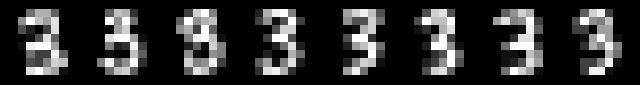

In [5]:
plt.figure(figsize=(8, 2))

for i in range(8):
    image = dataset[i][0].reshape(image_size, image_size)
    plt.subplot(1, 8, i + 1)
    plt.axis("off")
    plt.imshow(image.numpy(), cmap="gray")

plt.show()

## 导入脸


In [ ]:
import datasets
# load dataset from local directory "img/anime_face/data/"
ds= datasets.load_dataset("img/anime_face/data/")
# Check the dataset


Resolving data files:   0%|          | 0/21551 [00:00<?, ?it/s]

<module 'datasets' from '/home/ivansnow02/deep_learning/torch/lib/python3.11/site-packages/datasets/__init__.py'>


In [86]:
print(ds["train"])

Dataset({
    features: ['image'],
    num_rows: 21551
})


In [87]:
from torchvision.transforms.functional import to_pil_image


def apply_transform(example):
    # 如果图像已经是 Tensor，则转为 PIL Image
    if isinstance(example["image"], torch.Tensor):
        example["image"] = to_pil_image(example["image"])
    example["image"] = transform_anime(example["image"])
    return example


transform_anime = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# 应用转换
ds["train"] = ds["train"].map(apply_transform)

# 修改格式为 torch 格式
ds["train"].set_format(type="torch", columns=["image"])
train_dataset = ds["train"]

# 构建 DataLoader
dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

Map:   0%|          | 0/21551 [00:00<?, ? examples/s]

torch.Size([4, 1, 64, 64])


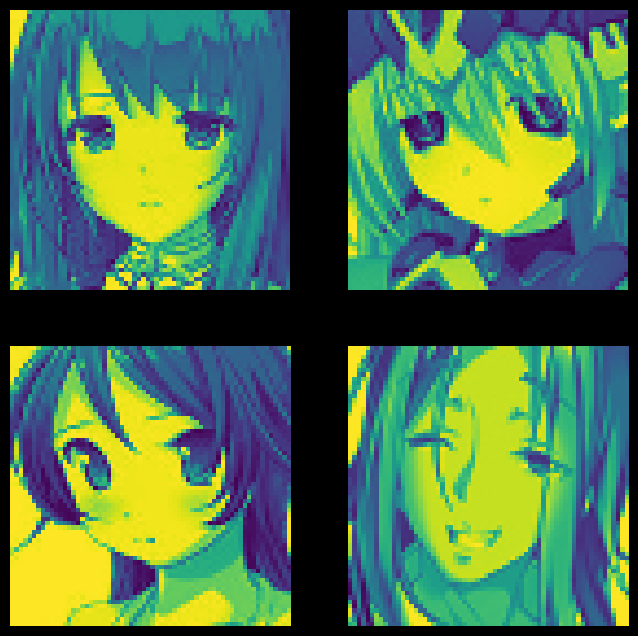

In [89]:
image_size = 64
batch_size = 4

# 取出一个 batch，并通过键获取图片 Tensor
for batch in dataloader:
    images = batch[
        "image"
    ]  # images 的形状通常为 [batch_size, C, H, W]，例如 torch.Size([4, 3, 64, 64])
    print(images.shape)
    break

# show the first 4 images
plt.figure(figsize=(8, 8))
for i in range(4):
    image = images[i].permute(1, 2, 0)  # 将通道维移动到最后
    plt.subplot(2, 2, i + 1)
    plt.axis("off")
    plt.imshow(image.numpy())
plt.show()

## 判别器


In [90]:
class ConvDiscriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.model = nn.Sequential(
            # 输入为 (batch, 1, 8, 8)
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 输出 (32, 4, 4)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 输出 (64, 4, 4)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(dropout_rate),
            nn.Flatten(),  # 展平为 (batch, 64*4*4)
            nn.Linear(64 * 4 * 4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [91]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self, dropout_rate=0.3):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.LeakyReLU(0.2),  # LeakyReLU 比 ReLU 更适合 GAN
            nn.Dropout(dropout_rate),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

## 生成器


In [92]:
# Quantum variables
n_qubits = 7  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 64  # Number of subgenerators for the patch method / N_G

In [93]:
# Quantum simulator
dev = qml.device("lightning.gpu", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [94]:
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_circuit(noise, weights):
    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

In [95]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList([
            nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
            for _ in range(n_generators)
        ])
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:
            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

## 训练

In [96]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

In [ ]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# 首先定义两个列表来存储判别器和生成器的损失值
d_losses = []
g_losses = []

# 重置迭代计数器
counter = 0

# 收集图像用于后续绘图
results = []

while True:
    for i, batch in enumerate(dataloader):
        # 训练判别器的数据
        data = batch["image"].reshape(-1, image_size * image_size).float()
        real_data = data.to(device)

        # 随机噪声，均匀分布在 [0,pi/2) 范围内
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # 训练判别器
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # 反向传播梯度
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # 训练生成器
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        # 存储每一步的损失值
        d_losses.append(errD.item())
        g_losses.append(errG.item())

        counter += 1

        # 显示损失值
        if counter % 10 == 0:
            print(
                f"迭代次数: {counter}, 判别器损失: {errD:0.3f}, 生成器损失: {errG:0.3f}"
            )
            test_images = (
                generator(fixed_noise).view(8, 1, image_size, image_size).cpu().detach()
            )

            # 每50次迭代保存图像
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="判别器损失")
plt.plot(g_losses, label="生成器损失")
plt.xlabel("迭代次数")
plt.ylabel("损失值")
plt.title("量子 GAN 训练损失")
plt.legend()
plt.grid(True)
plt.show()


# 为了更清晰地看到趋势，可以使用移动平均
def moving_average(data, window_size=50):
    return [np.mean(data[max(0, i - window_size) : i + 1]) for i in range(len(data))]


# 计算移动平均
d_losses_avg = moving_average(d_losses)
g_losses_avg = moving_average(g_losses)

# 绘制平滑后的损失曲线
plt.figure(figsize=(10, 5))
plt.plot(d_losses_avg, label="判别器损失 (移动平均)")
plt.plot(g_losses_avg, label="生成器损失 (移动平均)")
plt.xlabel("迭代次数")
plt.ylabel("损失值")
plt.title("量子 GAN 训练损失 (移动平均)")
plt.legend()
plt.grid(True)
plt.show()

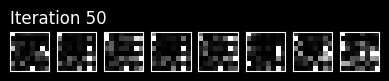

In [14]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0), subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):
        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.set_title(f"Iteration {50 + i * 50}", loc="left")
        fig.add_subplot(ax)

plt.show()